In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/zop
!ls

/content/drive/MyDrive/zop
diabetes.csv  uzop_grupni_projekt.ipynb


In [3]:
!pip install autofeat
!pip install lgbm

     |████████████████████████████████| 209 kB 7.6 MB/s 
ERROR: Could not find a version that satisfies the requirement lgbm (from versions: none)
ERROR: No matching distribution found for lgbm


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore') 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from autofeat import AutoFeatRegressor, AutoFeatClassifier
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector, SelectFromModel, RFE, f_classif, chi2
from sklearn.linear_model import LogisticRegression
import lightgbm as lgbm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, Flatten
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam, Adagrad, Adadelta, Adamax
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from keras.regularizers import l1, l2
from keras.initializers import HeNormal, HeUniform, GlorotUniform, GlorotNormal
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.ensemble import RandomForestClassifier

In [5]:
df = pd.read_csv('diabetes.csv')

In [6]:
def get_metrics(alg, pf=None):
    acc_train, acc_test, conf_matrices, precisions, recalls, f1_scores = [], [], [], [], [], []

    for i in range(100):
        model = alg()
        
        X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1), test_size=0.2)

        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        conf_matrices.append(confusion_matrix(y_test, test_pred))
        precisions.append(precision_score(y_test, test_pred))
        recalls.append(recall_score(y_test, test_pred))
        f1_scores.append(f1_score(y_test, test_pred))
        acc_train.append(accuracy_score(y_train, train_pred))
        acc_test.append(accuracy_score(y_test, test_pred))
    
    return acc_train, acc_test, conf_matrices, precisions, recalls, f1_scores, sum(conf_matrices)/len(conf_matrices)

# Removing outliers

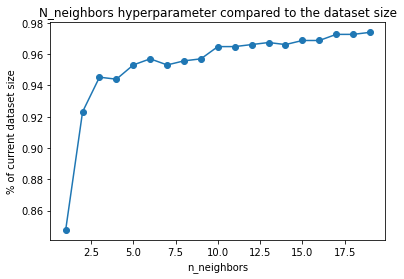

In [7]:
from sklearn.neighbors import LocalOutlierFactor

y = df['Outcome']
X = df.drop(columns=['Outcome'])

d = {}
for i in range(1, 20):
    lof = LocalOutlierFactor(n_neighbors=i)
    X_out = lof.fit_predict(X)
    d[i] = np.sum(X_out == 1)/len(X_out)

plt.plot(list(d.keys()), list(d.values()), '-o')
plt.xlabel('n_neighbors')
plt.ylabel('% of current dataset size')
plt.title('N_neighbors hyperparameter compared to the dataset size')
plt.show()

In [8]:
lof = LocalOutlierFactor(n_neighbors=4)
X_out = lof.fit_predict(X)

mask = X_out != -1

X = X.loc[mask, :]
y = y.loc[mask]

df = X[:]
df['Outcome'] = y[:]

print(len(X))
print(len(y))
print(len(df))

725
725
725


In [9]:
display(df[df['Pregnancies'] > 13])
df = df[df['Pregnancies'] <= 13]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
88,15,136,70,32,110,37.1,0.153,43,1
159,17,163,72,41,114,40.9,0.817,47,1
298,14,100,78,25,184,36.6,0.412,46,1
455,14,175,62,30,0,33.6,0.212,38,1


In [10]:
display(df[df['Glucose'] > 200])
df = df[df['Glucose'] <= 200]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [11]:
display(df[df['BloodPressure'] > 115])
df = df[df['BloodPressure'] <= 115]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [12]:
display(df[(df['BloodPressure'] < 40) & (df['BloodPressure'] != 0)])
df = df[(df['BloodPressure'] >= 40) | (df['BloodPressure'] == 0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
599,1,109,38,18,120,23.1,0.407,26,0


In [13]:
display(df[df['SkinThickness'] > 65])
df = df[df['SkinThickness'] <= 65]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [14]:
display(df[(df['Insulin'] > 500) & (df['Outcome'] == 0)])
df = df[(df['Insulin'] <= 500) | (df['Outcome'] == 1)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
286,5,155,84,44,545,38.7,0.619,34,0


In [15]:
display(df[(df['BMI'] > 50) & (df['Outcome'] == 0)])
df = df[(df['BMI'] <= 50) | (df['Outcome'] == 1)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
673,3,123,100,35,240,57.3,0.88,22,0


In [16]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000
mean,3.811978,120.683844,69.470752,20.278552,78.803621,31.955571,0.464336,32.997214,0.346797
std,3.246201,31.410967,18.110419,15.613010,108.080458,7.202455,0.319024,11.409824,0.476282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.400000,0.238250,24.000000,0.000000
50%,3.000000,116.500000,72.000000,23.000000,36.500000,32.000000,0.365000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,130.000000,36.375000,0.613750,40.000000,1.000000
max,13.000000,199.000000,110.000000,60.000000,600.000000,52.300000,2.288000,70.000000,1.000000


# Removing missing values

In [17]:
print('      Glucose missing values: ',len(df[df['Glucose'] == 0.0]))
print('BloodPressure missing values: ',len(df[df['BloodPressure'] == 0.0]))
print('SkinThickness missing values: ',len(df[df['SkinThickness'] == 0.0]))
print('          BMI missing values: ',len(df[df['BMI'] == 0.0]))

      Glucose missing values:  5
BloodPressure missing values:  29
SkinThickness missing values:  214
          BMI missing values:  7


In [18]:
df.loc[df['Glucose'] == 0.0, 'Glucose'] = np.nan
df.loc[df['BMI'] == 0.0, 'BMI'] = np.nan
df.loc[df['SkinThickness'] == 0.0, 'SkinThickness'] = np.nan
df.loc[df['BloodPressure'] == 0.0, 'BloodPressure'] = np.nan
df = df.interpolate()

# Feature engineering

In [19]:
X = df.drop(columns=['Outcome'])
y = df[['Outcome']]

display(X.head())
display(y.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,0,33.6,0.627,50
1,1,85.0,66.0,29.0,0,26.6,0.351,31
2,8,183.0,64.0,26.0,0,23.3,0.672,32
3,1,89.0,66.0,23.0,94,28.1,0.167,21
4,0,137.0,40.0,35.0,168,43.1,2.288,33


,Outcome
0,1
1,0
2,1
3,0
4,1


In [20]:
model = AutoFeatClassifier(verbose=1, feateng_steps=3)
X = model.fit_transform(X, y.values.reshape(-1))

[AutoFeat] The 3 step feature engineering process could generate up to 38556 features.
[AutoFeat] With 718 data points this new feature matrix would use about 0.11 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 37 transformed features from 8 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 3875 feature combinations from 990 original feature tuples - done.
[feateng] Step 3: transformation of new features
[feateng] Generated 14500 transformed features from 3875 original features - done.
[feateng] Generated altogether 20138 new features in 3 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 8148 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 25 fe

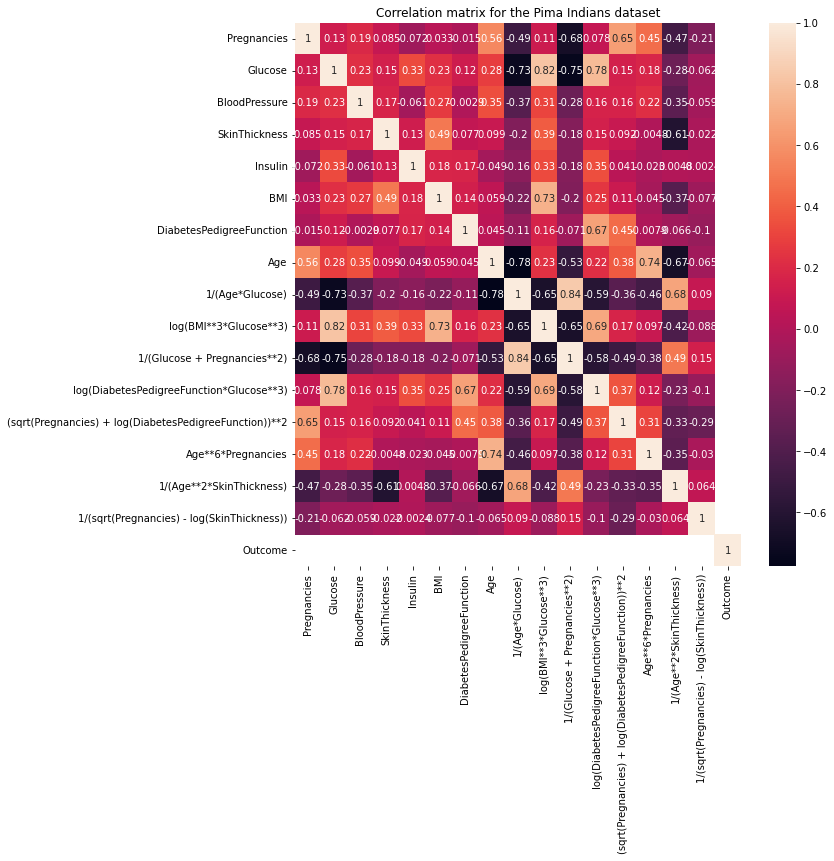

In [21]:
plt.figure(figsize=(10, 10))
sb.heatmap(pd.concat([X, y]).corr(),  annot=True)
plt.title('Correlation matrix for the Pima Indians dataset')
plt.show()

In [22]:
print(np.array(X.columns.tolist()))

['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age' '1/(Age*Glucose)'
 'log(BMI**3*Glucose**3)' '1/(Glucose + Pregnancies**2)'
 'log(DiabetesPedigreeFunction*Glucose**3)'
 '(sqrt(Pregnancies) + log(DiabetesPedigreeFunction))**2'
 'Age**6*Pregnancies' '1/(Age**2*SkinThickness)'
 '1/(sqrt(Pregnancies) - log(SkinThickness))']


# K-nearest neighbors

KNN pipeline using StandardScaler and MinMaxScaler without feature selection

In [23]:
pipeline1 = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier())
])

params = {
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': list(range(2, 51))
}

search = GridSearchCV(pipeline1, params)
search.fit(X, y)
bp1 = search.best_params_
print(search.best_score_)
print(search.best_params_)

pipeline2 = Pipeline(steps=[
    ('scaler', MinMaxScaler()), 
    ('knn', KNeighborsClassifier())
])
params = {
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': list(range(2, 51))
}

search = GridSearchCV(pipeline2, params)
search.fit(X, y)
bp2 = search.best_params_
print(search.best_score_)
print(search.best_params_)

0.7758741258741259
{'knn__n_neighbors': 41, 'knn__weights': 'uniform'}
0.7716977466977467
{'knn__n_neighbors': 31, 'knn__weights': 'distance'}


In [61]:
pipeline1 = lambda: Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=bp1['knn__n_neighbors'], weights=bp1['knn__weights']))
])
pipeline2 = lambda: Pipeline(steps=[
    ('scaler', MinMaxScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=bp2['knn__n_neighbors'], weights=bp2['knn__weights']))
])

print(np.mean(get_metrics(pipeline1)[1]))
print(np.mean(get_metrics(pipeline2)[1]))

0.7615277777777777
0.7593749999999999


KNN pipeline using StandardScaler and MinMaxScaler without feature selection using SelectKBest

In [25]:
pipeline3 = Pipeline(
    steps=[
        ('f_sel', SelectKBest()), 
        ('scaler', StandardScaler()), 
        ('knn', KNeighborsClassifier())
])

params = {
    'f_sel__score_func': [f_classif],
    'f_sel__k': list(range(1, len(X.columns.tolist())+1)),
    'knn__n_neighbors': list(range(2, 51)),
    'knn__weights': ['uniform', 'distance'],
}

search = GridSearchCV(pipeline3, params)
search.fit(X, y)
bp3 = search.best_params_
print(search.best_score_)
print(search.best_params_)

pipeline4 = Pipeline(
    steps=[
        ('f_sel', SelectKBest()), 
        ('scaler', MinMaxScaler()), 
        ('knn', KNeighborsClassifier())
])
params = {
    'f_sel__score_func': [f_classif],
    'f_sel__k': list(range(1, len(X.columns.tolist())+1)),
    'knn__n_neighbors': list(range(2, 51)),
    'knn__weights': ['uniform', 'distance'],
}

search = GridSearchCV(pipeline4, params)
search.fit(X, y)
bp4 = search.best_params_
print(search.best_score_)
print(search.best_params_)

0.7786033411033412
{'f_sel__k': 7, 'f_sel__score_func': <function f_classif at 0x7f3660ba4710>, 'knn__n_neighbors': 12, 'knn__weights': 'uniform'}
0.7731157731157732
{'f_sel__k': 12, 'f_sel__score_func': <function f_classif at 0x7f3660ba4710>, 'knn__n_neighbors': 32, 'knn__weights': 'distance'}


In [26]:
pipeline3 = lambda: Pipeline(
    steps=[
        ('f_sel', SelectKBest(score_func=bp3['f_sel__score_func'], k=bp3['f_sel__k'])), 
        ('scaler', StandardScaler()), 
        ('knn', KNeighborsClassifier(n_neighbors=bp3['knn__n_neighbors'], weights=bp3['knn__weights']))
])

pipeline4 = lambda: Pipeline(
    steps=[
        ('f_sel', SelectKBest(score_func=bp4['f_sel__score_func'], k=bp4['f_sel__k'])), 
        ('scaler', MinMaxScaler()), 
        ('knn', KNeighborsClassifier(n_neighbors=bp4['knn__n_neighbors'], weights=bp4['knn__weights']))
])

print(np.mean(get_metrics(pipeline3)[1]))
print(np.mean(get_metrics(pipeline4)[1]))

0.764375
0.7619444444444443


# Deep learning model

Deep learning model with a $1000 \times 1000$ architecture trained on a train validation test split (70%, 20%, 10%)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, shuffle=True)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

model = Sequential()

model.add(Dense(
    1000,
    kernel_regularizer=l1(1e-3),
    kernel_initializer=HeNormal(),
    activation='relu',
    input_shape=(len(X.columns.tolist()),)
    )
)

model.add(Dense(
    1000,
    kernel_regularizer=l1(1e-3),
    kernel_initializer=HeUniform(),
    activation='relu')
)

# model.add(Dropout(0.25))
# model.add(Flatten())

model.add(Dense(
    units=1,
    kernel_regularizer=l1(1e-3),
    activation='sigmoid')
)

model.compile(
    optimizer=Adam(learning_rate=0.0009),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

class_weight = compute_class_weight(y=y.values.reshape(-1), classes=np.unique(y.values.reshape(-1)), class_weight='balanced')

num_epochs = 1000
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=num_epochs,
    validation_data=(X_val, y_val),
    class_weight={0: class_weight[0], 1: class_weight[1]},
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=70, restore_best_weights=True)]
)

Epoch 1/1000
10/10 [==============================] - 1s 55ms/step - loss: 42.0378 - accuracy: 0.6990 - val_loss: 38.7823 - val_accuracy: 0.7986
Epoch 2/1000
10/10 [==============================] - 0s 30ms/step - loss: 36.8031 - accuracy: 0.7229 - val_loss: 34.0979 - val_accuracy: 0.7708
Epoch 3/1000
10/10 [==============================] - 0s 31ms/step - loss: 32.0091 - accuracy: 0.7803 - val_loss: 29.5875 - val_accuracy: 0.7500
Epoch 4/1000
10/10 [==============================] - 0s 30ms/step - loss: 27.6309 - accuracy: 0.7803 - val_loss: 25.3008 - val_accuracy: 0.8125
Epoch 5/1000
10/10 [==============================] - 0s 32ms/step - loss: 23.6156 - accuracy: 0.7994 - val_loss: 21.5260 - val_accuracy: 0.8264
Epoch 6/1000
10/10 [==============================] - 0s 30ms/step - loss: 20.0154 - accuracy: 0.8089 - val_loss: 18.1864 - val_accuracy: 0.8264
Epoch 7/1000
10/10 [==============================] - 0s 31ms/step - loss: 16.8957 - accuracy: 0.8105 - val_loss: 15.3380 - val_ac

In [28]:
y_pred = model.predict(scaler.transform(X_test)).reshape(-1) >= 0.5

print(accuracy_score(y_pred, y_test.values.reshape(-1)))

0.7222222222222222


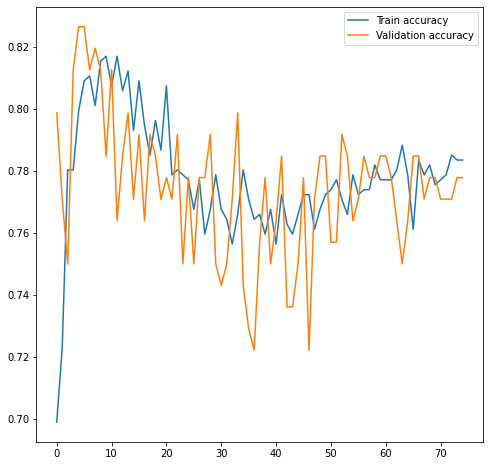

In [29]:
plt.figure(figsize=(8, 8))
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Train accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

# Logistic regression

Pipeline that uses SelectKBest, PolynomialFeatures, StandardScaler and a logistic regression classifier

In [30]:
pipeline5 = Pipeline(steps=[('fs',SelectKBest()), ('pf',PolynomialFeatures()), ('scaler', StandardScaler()),('log_reg', LogisticRegression())])

params = {
    'log_reg__C': [i*(10**y) for y in range(-5, 5) for i in range(1, 3)],
    'log_reg__penalty': ['l1', 'l2'],
    'fs__score_func': [f_classif],
    'fs__k': list(range((len(X.columns)-3),(len(X.columns)))),
    'pf__degree': [4, 5]
}

search = GridSearchCV(pipeline5, params)
search.fit(X, y)
bp5 = search.best_params_
print(search.best_score_)
print(search.best_params_) 

0.7702700077700078
{'fs__k': 15, 'fs__score_func': <function f_classif at 0x7f3660ba4710>, 'log_reg__C': 0.002, 'log_reg__penalty': 'l2', 'pf__degree': 4}


In [31]:
pipeline5 = lambda: Pipeline(steps=[
            ('fs', SelectKBest(score_func=bp5['fs__score_func'], k=bp5['fs__k'])),
            ('scaler', StandardScaler()),
            ('pf',PolynomialFeatures(degree=bp5['pf__degree'])),
            ('log_reg', LogisticRegression(C=bp5['log_reg__C'], penalty=bp5['log_reg__penalty']))
])

print(np.mean(get_metrics(pipeline5)[1]))

0.7350694444444446


Pipeline that uses SelectKBest, PolynomialFeatures, MinMaxScaler and a logistic regression classifier

In [32]:
pipeline6 = Pipeline(steps=[('fs',SelectKBest()), ('pf',PolynomialFeatures()), ('scaler', MinMaxScaler()),('log_reg', LogisticRegression())])

params = {
    'log_reg__C': [i*(10**y) for y in range(-5, 5) for i in range(1, 3)],
    'log_reg__penalty': ['l1', 'l2'],
    'fs__score_func': [f_classif],
    'fs__k': list(range((len(X.columns)-3),(len(X.columns)))),
    'pf__degree': [2, 3, 4]
}

search = GridSearchCV(pipeline6, params)
search.fit(X, y)
bp6 = search.best_params_
print(search.best_score_)
print(search.best_params_) 

0.7688811188811189
{'fs__k': 15, 'fs__score_func': <function f_classif at 0x7f3660ba4710>, 'log_reg__C': 1, 'log_reg__penalty': 'l2', 'pf__degree': 3}


In [33]:
pipeline6 = lambda: Pipeline(steps=[
            ('fs', SelectKBest(score_func=bp6['fs__score_func'], k=bp6['fs__k'])),
            ('scaler', StandardScaler()),
            ('pf',PolynomialFeatures(degree=bp6['pf__degree'])),
            ('log_reg', LogisticRegression(C=bp6['log_reg__C'], penalty=bp6['log_reg__penalty']))
])

print(np.mean(get_metrics(pipeline6)[1]))

0.6959027777777779


Pipeline that uses RFE, PolynomialFeatures, StandardScaler and a logistic regression classifier

In [34]:
pipeline7 = Pipeline(steps=[('fs', RFE(estimator=LogisticRegression())), ('pf',PolynomialFeatures()), ('scaler', StandardScaler()),('log_reg', LogisticRegression())])
params = {
    'log_reg__C': [i*(10**y) for y in range(-5, 5) for i in range(1, 3)],
    'log_reg__penalty': ['l1', 'l2'],
    'fs__n_features_to_select': [len(X.columns)-1],
    'pf__degree': [2, 3, 4]
}

search = GridSearchCV(pipeline7, params)
search.fit(X, y)
bp7 = search.best_params_
print(search.best_score_)
print(search.best_params_)

0.768900543900544
{'fs__n_features_to_select': 15, 'log_reg__C': 0.1, 'log_reg__penalty': 'l2', 'pf__degree': 2}


In [35]:
pipeline7 = lambda: Pipeline(steps=[
            ('fs', RFE(estimator=LogisticRegression(), n_features_to_select=bp7['fs__n_features_to_select'])),
            ('scaler', StandardScaler()),
            ('pf', PolynomialFeatures(degree=bp7['pf__degree'])),
            ('log_reg', LogisticRegression(C=bp7['log_reg__C'], penalty=bp7['log_reg__penalty']))
])

print(np.mean(get_metrics(pipeline7)[1]))

0.7484027777777778


Pipeline that uses RFE, PolynomialFeatures, MinMaxScaler and a logistic regression classifier

In [40]:
pipeline8 = Pipeline(steps=[('fs', RFE(estimator=LogisticRegression())), ('pf',PolynomialFeatures()), ('scaler', MinMaxScaler()), ('log_reg', LogisticRegression())])
params = {
    'log_reg__C': [i*(10**y) for y in range(-5, 5) for i in range(1, 3)],
    'log_reg__penalty': ['l1', 'l2'],
    'fs__n_features_to_select':[(len(X.columns)-1)],
    'pf__degree': [2, 3, 4]
}

search = GridSearchCV(pipeline8, params)
search.fit(X, y)
bp8 = search.best_params_
print(search.best_score_)
print(search.best_params_)

0.7744658119658119
{'fs__n_features_to_select': 15, 'log_reg__C': 1, 'log_reg__penalty': 'l2', 'pf__degree': 3}


In [41]:
pipeline8 = lambda: Pipeline(steps=[
            ('fs', RFE(estimator=LogisticRegression(), n_features_to_select=bp8['fs__n_features_to_select'])),
            ('scaler', MinMaxScaler()),
            ('pf', PolynomialFeatures(degree=bp8['pf__degree'])),
            ('log_reg', LogisticRegression(C=bp8['log_reg__C'], penalty=bp8['log_reg__penalty']))
])

print(np.mean(get_metrics(pipeline8)[1]))

0.7623611111111108


# LGBM



Pipeline that uses SelectKBest feature selection and a LGBM classifier

In [38]:
pipeline9 = Pipeline(steps=[('fs',SelectKBest()), ('lgbm', lgbm.LGBMClassifier())])
params={
    'lgbm__max_depth': list(range(4,7)),
    'lgbm__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'lgbm__n_estimators': list(range(10, 40, 10)),
    'lgbm__reg_alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'lgbm__reg_lambda': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'fs__score_func': [f_classif],
    'fs__k': list(range((len(X.columns)-2),(len(X.columns)))),
}

search = GridSearchCV(pipeline9, params)
search.fit(X, y)
bp9 = search.best_params_
print(search.best_score_)
print(search.best_params_)

0.7661033411033411
{'fs__k': 15, 'fs__score_func': <function f_classif at 0x7f3660ba4710>, 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 4, 'lgbm__n_estimators': 30, 'lgbm__reg_alpha': 0.5, 'lgbm__reg_lambda': 0.01}


In [39]:
pipeline9 = lambda: Pipeline(steps=[
        ('fs',SelectKBest()),
        ('lgbm', lgbm.LGBMClassifier())
])

print(np.mean(get_metrics(pipeline9)[1]))

0.7306250000000002


# Ensembles

Pipeline that uses a MinMaxScaler and a random forest classifier ensemble without feature selection

In [42]:
pipeline10 = Pipeline(steps=[('scaler', MinMaxScaler()), ('ensemble', RandomForestClassifier())])

params = {
    'ensemble__n_estimators': list(range(2, 30)),
    'ensemble__criterion': ['gini', 'entropy'],
    'ensemble__max_depth': list(range(2, 20)),
    'ensemble__class_weight': ['balanced', 'balanced_subsample', None]
}

search = GridSearchCV(pipeline10, params)
search.fit(X, y['Outcome'])

bp10 = search.best_params_
print(search.best_score_)
print(search.best_params_)

0.7855477855477856
{'ensemble__class_weight': 'balanced_subsample', 'ensemble__criterion': 'entropy', 'ensemble__max_depth': 10, 'ensemble__n_estimators': 28}


In [43]:
pipeline10 = lambda: Pipeline(steps=[
        ('scaler', MinMaxScaler()), 
        ('ensemble', RandomForestClassifier(
            n_estimators=bp10['ensemble__n_estimators'], 
            criterion=bp10['ensemble__criterion'], 
            max_depth=bp10['ensemble__max_depth'], 
            class_weight=bp10['ensemble__class_weight'])
        )
        
])

print(np.mean(get_metrics(pipeline10)[1]))

0.752013888888889


Pipeline that uses a StandardScaler and a random forest classifier ensemble without feature selection

In [44]:
pipeline11 = Pipeline(steps=[('scaler', StandardScaler()), ('ensemble', RandomForestClassifier())])

params = {
    'ensemble__n_estimators': list(range(5, 35)),
    'ensemble__criterion': ['gini', 'entropy'],
    'ensemble__max_depth': list(range(2, 20)),
    'ensemble__class_weight': ['balanced', 'balanced_subsample', None]
}

search = GridSearchCV(pipeline11, params)
search.fit(X, y['Outcome'])

bp11 = search.best_params_
print(search.best_score_)
print(search.best_params_)

0.7814102564102564
{'ensemble__class_weight': 'balanced', 'ensemble__criterion': 'entropy', 'ensemble__max_depth': 13, 'ensemble__n_estimators': 24}


In [45]:
pipeline11 = lambda: Pipeline(steps=[
        ('scaler', StandardScaler()), 
        ('ensemble', RandomForestClassifier(
            n_estimators=bp11['ensemble__n_estimators'], 
            criterion=bp11['ensemble__criterion'], 
            max_depth=bp11['ensemble__max_depth'], 
            class_weight=bp11['ensemble__class_weight'])
        )
        
])

print(np.mean(get_metrics(pipeline11)[1]))

0.7516666666666667


Pipeline that uses SelectKBest feature selection, StandardScaler and a random forest classifier ensemble

In [46]:
pipeline12 = Pipeline(steps=[('fs', SelectKBest()), ('scaler', StandardScaler()),('ensemble', RandomForestClassifier())])
params = {
    'ensemble__n_estimators': list(range(15, 30)),
    'ensemble__criterion': ['gini', 'entropy'],
    'ensemble__max_depth': list(range(4, 10)),
    'ensemble__class_weight': ['balanced', 'balanced_subsample', None],
    'fs__score_func':[f_classif],
    'fs__k':list(range((len(X.columns)-3),(len(X.columns))))
}
search = GridSearchCV(pipeline12, params)
search.fit(X, y['Outcome'])
bp12 = search.best_params_
print(search.best_score_)
print(search.best_params_) 


0.7841977466977468
{'ensemble__class_weight': 'balanced', 'ensemble__criterion': 'entropy', 'ensemble__max_depth': 9, 'ensemble__n_estimators': 23, 'fs__k': 13, 'fs__score_func': <function f_classif at 0x7f3660ba4710>}


In [47]:
pipeline12 = lambda: Pipeline(steps=[
        ('fs', SelectKBest(score_func=bp12['fs__score_func'], k=bp12['fs__k'])),
        ('scaler', StandardScaler()), 
        ('ensemble', RandomForestClassifier(
            n_estimators=bp12['ensemble__n_estimators'], 
            criterion=bp12['ensemble__criterion'], 
            max_depth=bp12['ensemble__max_depth'], 
            class_weight=bp12['ensemble__class_weight'])
        )
        
])

print(np.mean(get_metrics(pipeline12)[1]))

0.7550694444444445


Pipeline that uses SelectKBest feature selection, MinMaxScaler and a random forest classifier ensemble

In [48]:
pipeline13 = Pipeline(steps=[('fs',SelectKBest()),('scaler', MinMaxScaler()),('ensemble', RandomForestClassifier())])
params = {
    'ensemble__n_estimators': list(range(15, 30)),
    'ensemble__criterion': ['gini', 'entropy'],
    'ensemble__max_depth': list(range(4, 10)),
    'ensemble__class_weight': ['balanced', 'balanced_subsample', None],
    'fs__score_func':[f_classif],
    'fs__k':list(range((len(X.columns)-3),(len(X.columns))))
}

search = GridSearchCV(pipeline13, params)
search.fit(X, y['Outcome'])
bp13 = search.best_params_
print(search.best_score_)
print(search.best_params_) 

0.7841977466977468
{'ensemble__class_weight': 'balanced', 'ensemble__criterion': 'entropy', 'ensemble__max_depth': 8, 'ensemble__n_estimators': 24, 'fs__k': 15, 'fs__score_func': <function f_classif at 0x7f3660ba4710>}


In [49]:
pipeline13 = lambda: Pipeline(steps=[
        ('fs', SelectKBest(score_func=bp13['fs__score_func'], k=bp13['fs__k'])),
        ('scaler', MinMaxScaler()), 
        ('ensemble', RandomForestClassifier(
            n_estimators=bp13['ensemble__n_estimators'], 
            criterion=bp13['ensemble__criterion'], 
            max_depth=bp13['ensemble__max_depth'], 
            class_weight=bp13['ensemble__class_weight'])
        )
        
])

print(np.mean(get_metrics(pipeline13)[1]))

0.7572916666666667


Pipeline that uses RFE feature selection, StandardScaler and a random forest classifier ensemble

In [50]:
pipeline14 = Pipeline(steps=[('fs',RFE(estimator=RandomForestClassifier())),('scaler', StandardScaler()),('ensemble', RandomForestClassifier())])
params = {
    'ensemble__n_estimators': list(range(20, 30)),
    'ensemble__criterion': ['gini', 'entropy'],
    'ensemble__max_depth': list(range(4, 10)),
    'ensemble__class_weight': ['balanced', 'balanced_subsample', None],
    'fs__n_features_to_select':[(len(X.columns)-1)]
}
search = GridSearchCV(pipeline14, params)
search.fit(X, y['Outcome'])
bp14 = search.best_params_
print(search.best_score_)
print(search.best_params_) 

0.781400543900544
{'ensemble__class_weight': 'balanced', 'ensemble__criterion': 'entropy', 'ensemble__max_depth': 6, 'ensemble__n_estimators': 22, 'fs__n_features_to_select': 15}


In [53]:
pipeline14 = lambda: Pipeline(steps=[
        ('fs', RFE(estimator=RandomForestClassifier(), n_features_to_select=bp14['fs__n_features_to_select'])),
        ('scaler', StandardScaler()), 
        ('ensemble', RandomForestClassifier(
            n_estimators=bp14['ensemble__n_estimators'], 
            criterion=bp14['ensemble__criterion'], 
            max_depth=bp14['ensemble__max_depth'], 
            class_weight=bp14['ensemble__class_weight'])
        )
        
])

print(np.mean(get_metrics(pipeline14)[1]))

0.7628472222222222


Pipeline that uses RFE feature selection, MinMaxScaler and a random forest classifier ensemble

In [62]:
pipeline15 = Pipeline(steps=[('fs',RFE(estimator=RandomForestClassifier())), ('scaler', MinMaxScaler()),('ensemble', RandomForestClassifier())])
params = {
    'ensemble__n_estimators': list(range(20, 30)),
    'ensemble__criterion': ['gini', 'entropy'],
    'ensemble__max_depth': list(range(4, 10)),
    'ensemble__class_weight': ['balanced', 'balanced_subsample', None],
    'fs__n_features_to_select':[(len(X.columns)-1)]
}
search = GridSearchCV(pipeline15, params)
search.fit(X, y['Outcome'])
bp15 = search.best_params_
print(search.best_score_)
print(search.best_params_) 

0.7842074592074592
{'ensemble__class_weight': 'balanced_subsample', 'ensemble__criterion': 'entropy', 'ensemble__max_depth': 8, 'ensemble__n_estimators': 28, 'fs__n_features_to_select': 15}


In [65]:
pipeline15 = lambda: Pipeline(steps=[
        ('fs', RFE(estimator=RandomForestClassifier(), n_features_to_select=bp15['fs__n_features_to_select'])),
        ('scaler', MinMaxScaler()), 
        ('ensemble', RandomForestClassifier(
            n_estimators=bp15['ensemble__n_estimators'], 
            criterion=bp15['ensemble__criterion'], 
            max_depth=bp15['ensemble__max_depth'], 
            class_weight=bp15['ensemble__class_weight'])
        )
        
])

print(np.mean(get_metrics(pipeline15)[1]))

0.7585416666666669


# Metric evaluation


In [66]:
metrics={"standardscaler_knn":pipeline1,"minmaxscaler_knn":pipeline2,"selectkbest_standardscaler_knn":pipeline3,"selectkbest_minmaxscaler_knn":pipeline4,
         "selectkbest_polynomialfeatures_standardscaler_logisticregression":pipeline5,"selectkbest_polynomialfeatures_minmaxscaler_logisticregression":pipeline6,
         "rfe_polynomialfeatures_standardscaler_logisticregression":pipeline7,"rfe_polynomialfeatures_minmaxscaler_logisticregression":pipeline8,
         "selectkbest_lgbmclassifier":pipeline9,"minmaxscaler_randomforestclassifier":pipeline10,"standardscaler_randomforestclassifier":pipeline11,
         "selectkbest_standardscaler_randomforestclassifier":pipeline12,"selectkbest_minmaxscaler_randomforestclassifier":pipeline13,
         "rfe_standardscaler_randomforestclassifier":pipeline14,"rfe_minmaxscaler_randomforestclassifier":pipeline15}


In [ ]:
model_metrics=[]
for name,pipe in metrics.items():
  row={}
  pipe_metrics=get_metrics(pipe)
  row["acc_train"]=np.mean(pipe_metrics[0])
  row["acc_test"]=np.mean(pipe_metrics[1])
  row["conf_matrix"]=pipe_metrics[6]
  row["precision"]=np.mean(pipe_metrics[3])
  row["recall"]=np.mean(pipe_metrics[4])
  row["f1_score"]=np.mean(pipe_metrics[5])
  model_metrics.append(row)

In [84]:
result_dataframe=pd.DataFrame.from_dict(model_metrics)
result_dataframe["names"]=pd.Series(list(metrics.keys()))
display(result_dataframe)

,acc_train,acc_test,conf_matrix,precision,recall,f1_score,names
0,0.779268,0.760139,"[[81.36, 12.52], [22.02, 28.1]]",0.693580,0.561980,0.617536,standardscaler_knn
1,1.000000,0.760556,"[[80.29, 13.77], [20.71, 29.23]]",0.682249,0.586509,0.627473,minmaxscaler_knn
2,0.800941,0.762639,"[[82.91, 11.34], [22.84, 26.91]]",0.706190,0.543394,0.609530,selectkbest_standardscaler_knn
3,1.000000,0.757153,"[[79.9, 14.03], [20.94, 29.13]]",0.679111,0.582480,0.623514,selectkbest_minmaxscaler_knn
4,0.862247,0.732292,"[[82.09, 11.85], [26.7, 23.36]]",0.665240,0.467484,0.545978,selectkbest_polynomialfeatures_standardscaler_...
5,0.958066,0.689653,"[[71.45, 22.51], [22.18, 27.86]]",0.554689,0.558029,0.553144,selectkbest_polynomialfeatures_minmaxscaler_lo...
6,0.812491,0.751250,"[[79.9, 15.18], [20.64, 28.28]]",0.652544,0.578600,0.610599,rfe_polynomialfeatures_standardscaler_logistic...
7,0.797787,0.775000,"[[81.95, 12.79], [19.61, 29.65]]",0.699894,0.602747,0.644928,rfe_polynomialfeatures_minmaxscaler_logisticre...
8,0.999983,0.733125,"[[76.34, 17.69], [20.74, 29.23]]",0.623791,0.585352,0.600944,selectkbest_lgbmclassifier
9,0.987230,0.753681,"[[76.54, 17.97], [17.5, 31.99]]",0.642863,0.647772,0.642219,minmaxscaler_randomforestclassifier


In [77]:

acc_train, acc_test, conf_matrices, precisions, recalls, f1_scores = [], [], [], [], [], []
for i in range(10):

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, shuffle=True)

  scaler = StandardScaler()

  X_train = scaler.fit_transform(X_train)
  X_val = scaler.transform(X_val)

  model = Sequential()

  model.add(Dense(
      1000,
      kernel_regularizer=l1(1e-3),
      kernel_initializer=HeNormal(),
      activation='relu',
      input_shape=(len(X.columns.tolist()),)
      )
  )

  model.add(Dense(
      1000,
      kernel_regularizer=l1(1e-3),
      kernel_initializer=HeUniform(),
      activation='relu')
  )

  # model.add(Dropout(0.25))
  # model.add(Flatten())

  model.add(Dense(
      units=1,
      kernel_regularizer=l1(1e-3),
      activation='sigmoid')
  )

  model.compile(
      optimizer=Adam(learning_rate=0.0009),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=['accuracy']
  )

  class_weight = compute_class_weight(y=y.values.reshape(-1), classes=np.unique(y.values.reshape(-1)), class_weight='balanced')

  num_epochs = 1000
  history = model.fit(
      X_train, y_train,
      batch_size=64,
      epochs=num_epochs,
      validation_data=(X_val, y_val),
      class_weight={0: class_weight[0], 1: class_weight[1]},
      callbacks=[EarlyStopping(monitor='val_accuracy', patience=70, restore_best_weights=True)]
  )
  test_pred = model.predict(scaler.transform(X_test)).reshape(-1) >= 0.5
  train_pred = model.predict(X_train).reshape(-1) >= 0.5
  
  conf_matrices.append(confusion_matrix(y_test, test_pred))
  precisions.append(precision_score(y_test, test_pred))
  recalls.append(recall_score(y_test, test_pred))
  f1_scores.append(f1_score(y_test, test_pred))
  acc_train.append(accuracy_score(y_train, train_pred))
  acc_test.append(accuracy_score(y_test, test_pred))


Epoch 1/1000
10/10 [==============================] - 1s 47ms/step - loss: 42.1875 - accuracy: 0.7150 - val_loss: 39.2219 - val_accuracy: 0.7431
Epoch 2/1000
10/10 [==============================] - 0s 30ms/step - loss: 36.8620 - accuracy: 0.7389 - val_loss: 33.9874 - val_accuracy: 0.7569
Epoch 3/1000
10/10 [==============================] - 0s 32ms/step - loss: 31.7747 - accuracy: 0.7994 - val_loss: 29.1247 - val_accuracy: 0.7778
Epoch 4/1000
10/10 [==============================] - 0s 25ms/step - loss: 27.1546 - accuracy: 0.7946 - val_loss: 24.6774 - val_accuracy: 0.8333
Epoch 5/1000
10/10 [==============================] - 0s 25ms/step - loss: 22.9471 - accuracy: 0.8153 - val_loss: 20.7141 - val_accuracy: 0.8264
Epoch 6/1000
10/10 [==============================] - 0s 26ms/step - loss: 19.1824 - accuracy: 0.8264 - val_loss: 17.2796 - val_accuracy: 0.8333
Epoch 7/1000
10/10 [==============================] - 0s 24ms/step - loss: 15.9676 - accuracy: 0.8232 - val_loss: 14.3396 - val_ac

In [85]:
result_dataframe.loc[len(result_dataframe)]=[
  np.mean(acc_train),
  np.mean(acc_test),
  sum(conf_matrices)/len(conf_matrices),
  np.mean(precisions),
  np.mean(recalls),
  np.mean(f1_scores),
  "standardscaler_nn"]

In [86]:
display(result_dataframe)

,acc_train,acc_test,conf_matrix,precision,recall,f1_score,names
0,0.779268,0.760139,"[[81.36, 12.52], [22.02, 28.1]]",0.693580,0.561980,0.617536,standardscaler_knn
1,1.000000,0.760556,"[[80.29, 13.77], [20.71, 29.23]]",0.682249,0.586509,0.627473,minmaxscaler_knn
2,0.800941,0.762639,"[[82.91, 11.34], [22.84, 26.91]]",0.706190,0.543394,0.609530,selectkbest_standardscaler_knn
3,1.000000,0.757153,"[[79.9, 14.03], [20.94, 29.13]]",0.679111,0.582480,0.623514,selectkbest_minmaxscaler_knn
4,0.862247,0.732292,"[[82.09, 11.85], [26.7, 23.36]]",0.665240,0.467484,0.545978,selectkbest_polynomialfeatures_standardscaler_...
5,0.958066,0.689653,"[[71.45, 22.51], [22.18, 27.86]]",0.554689,0.558029,0.553144,selectkbest_polynomialfeatures_minmaxscaler_lo...
6,0.812491,0.751250,"[[79.9, 15.18], [20.64, 28.28]]",0.652544,0.578600,0.610599,rfe_polynomialfeatures_standardscaler_logistic...
7,0.797787,0.775000,"[[81.95, 12.79], [19.61, 29.65]]",0.699894,0.602747,0.644928,rfe_polynomialfeatures_minmaxscaler_logisticre...
8,0.999983,0.733125,"[[76.34, 17.69], [20.74, 29.23]]",0.623791,0.585352,0.600944,selectkbest_lgbmclassifier
9,0.987230,0.753681,"[[76.54, 17.97], [17.5, 31.99]]",0.642863,0.647772,0.642219,minmaxscaler_randomforestclassifier
